## Deep learing project no.1

Marek Szydłowski 136633 <br>
Wotjek Tomczak 145467

In [25]:
from pathlib import Path

import pandas as pd
import numpy as np
import re

import PIL
from PIL import Image
from IPython.display import display
import cv2

In [2]:
DATA_PATH = 'data/256_ObjectCategories/'

In [3]:
# TODO: Add downloading files

In [4]:
data_check = Path(DATA_PATH)

assert data_check.exists(), "Please download the data first: vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar"

In [16]:
img = cv2.imread(DATA_PATH + '001.ak47/001_0001.jpg')
img.shape

(278, 499, 3)

In [20]:
# animal kingdom here we come
animal_codes = np.array(
    [
        "007",
        "009",
        "024",
        "028",
        "034",
        "038",
        "040",
        "049",
        "052",
        "056",
        "057",
        "060",
        "064",
        "065",
        "080",
        "084",
        "085",
        "087",
        "089",
        "090",
        "093",
        "100",
        "105",
        "106",
        "111",
        "113",
        "114",
        "116",
        "121",
        "124",
        "129",
        "134",
        "150",
        "151",
        "152",
        "158",
        "164",
        "166",
        "168",
        "179",
        "186",
        "189",
        "190",
        "198",
        "201",
        "207",
        "228",
        "236",
        "250",
        "254",
        "256",
    ]
)

In [81]:
images = {}
for data_dir in Path(DATA_PATH).iterdir():
    num, _ = data_dir.name.split(".")
    if num in animal_codes:
        for f in data_dir.iterdir():
            if not f.is_file():
                continue

            if data_dir.name not in images:
                images[data_dir.name] = 1
            else:
                images[data_dir.name] += 1

df = (
    pd.DataFrame.from_dict(images, "index")
    .reset_index()
    .rename({0: "length", "index": "name"}, axis=1)
)

In [82]:
len(df)

51

In [83]:
median = df['length'].median()

# x < 90% median

In [84]:
modify_thershold = 0.1
df = df[
    df["length"].apply(lambda x: False if x < (1 - modify_thershold) * median else True)
]

df["to_trim"] = (
    df["length"]
    .apply(lambda x: True if x > (1 + modify_thershold) * median else False)
    .reset_index(drop=True)
)


In [85]:
len(df)

35

In [80]:
df

,name,length,to_trim
0,007.bat,106,False
1,009.bear,102,False
2,024.butterfly,112,False
3,028.camel,110,False
4,034.centipede,100,False
5,038.chimp,110,False
6,040.cockroach,124,True
7,049.cormorant,106,False
9,056.dog,102,False
10,057.dolphin-101,106,False


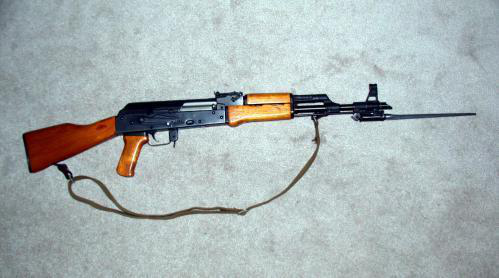

In [18]:
with Image.open(DATA_PATH + '001.ak47/001_0001.jpg') as img:
    display(img)